Số lượng nhà máy: F

Số lượng sản phẩm: K

Số lượng nhà kho: H

Nhu cầu của nhà kho đối với mỗi loại mặt hàng: $Demand \in \mathbb{R}_{\geq 0}^k$

Khả năng sản xuất của nhà máy: $SupplyMax_f \in \mathbb{R}_{\geq 0}^k$

max\_distance: khoảng cách lớn nhất được đi

D: distance matrix

A: matrix config

Giả sử $W_{fh}^k$ là lượng hàng k vận chuyển từ nhà máy f đến kho h.

$a_{fh}$ là biến nhị phân biểu thị có đường đi từ nhà máy đến kho.


Hàng phải được vận chuyển từ nhà máy đến kho:

\begin{center}
    $a_{fh} = 1 \text{ nếu } A[f,h]=2$
\end{center}


Tổng lượng hàng vận chuyển nhỏ hơn hoặc bằng tổng lượng hàng nhà máy cung cấp:
\begin{center}
    $\sum\limits_{h \in H} W_{fh}^k \leq SupplyMax_f \forall f \in F$
\end{center}

Tổng lượng hàng nhận được từ nhà máy bằng lượng yêu cầu của kho.
\begin{center}
    $\sum\limits_{h \in H} W_{fh}^k = Demand_{fk} \forall f \in F$
\end{center}

Giới hạn khoảng cách đi:
\begin{center}
    $a_{fh}*D_{fh} \leq max\_distance$
\end{center}

Hàm mục tiêu:
\begin{center}
    Minimize Cost: $\sum\limits_{f \in F}\sum\limits_{h \in H} \sum\limits_{k \in K} W_{fh}^k*transportCost*distance_{fh} $ 
\end{center}

trong đó:

$transportCost_{fh}$ là hệ số vận chuyển hàng theo khoảng cách từ nhà  máy f đến nhà kho h

$distance_{fh}$ là khoảng cách từ nhà máy f đến nhà kho h.

In [2]:
from ortools.linear_solver import pywraplp
import numpy as np
import math
import time
from numba import njit

In [3]:
# Constants definition
NUM_FACTORIES: int = 12
NUM_HUBS: int = 35
NUM_SKUS: int = 10

Fake data

In [5]:
@njit
def generate_fake_data():
    """Generate fake data for supply, demand, and locations."""
    np.random.seed(42)  # Ensuring reproducibility
    supply = np.random.randint(10, 10000, (NUM_FACTORIES, NUM_SKUS))
    demand = np.random.randint(1, 50, (NUM_HUBS, NUM_SKUS))
    factory_locations = np.random.randint(1, 1000, (NUM_FACTORIES, 2))
    hub_locations = np.random.randint(1, 1000, (NUM_HUBS, 2))
    a = np.random.randint(0, 3, (NUM_FACTORIES, NUM_HUBS))
    return supply, demand, factory_locations, hub_locations, a

In [6]:
@njit
def calculate_distance(points1: np.ndarray, points2: np.ndarray) -> np.ndarray:
    """Calculate Euclidean distances between two sets of coordinates."""
    num_points1 = points1.shape[0]
    num_points2 = points2.shape[0]
    distances = np.empty((num_points1, num_points2), dtype=np.float32)
    for i in range(num_points1):
        for j in range(num_points2):
            distances[i, j] = math.sqrt((points1[i, 0] - points2[j, 0]) ** 2 +
                                        (points1[i, 1] - points2[j, 1]) ** 2)
    return distances

In [7]:
@njit
def compute_index1(f: int, h: int, s: int) -> int:
    """Calculate the index for factory-hub flow variables."""
    return f * NUM_HUBS * NUM_SKUS + h * NUM_SKUS + s

In [8]:
@njit
def populate_cost_coefficients(DM_fh: np.ndarray, onoff_hub: np.ndarray) -> np.ndarray:
    """Populate and return the cost coefficients for the linear programming problem, considering active hubs and customers."""
    num_variables = NUM_FACTORIES * NUM_HUBS * NUM_SKUS
    cost_coefficients = np.zeros(num_variables, dtype=np.float32)
    for f in range(NUM_FACTORIES):
        for h in range(NUM_HUBS):
            if onoff_hub[h]:  # Only consider active hubs
                for s in range(NUM_SKUS):
                    idx = compute_index1(f, h, s)
                    cost_coefficients[idx] = DM_fh[f, h]
    return cost_coefficients

In [9]:
# Generate data
supply, demand, factory_locations, hub_locations, a= generate_fake_data()
DM_fh = calculate_distance(factory_locations, hub_locations)
onoff_hub = np.random.randint(1, 3, len(hub_locations))  # Active hubs
max_distance = round(np.mean(DM_fh))

# Populate cost coefficients
cost_coefficients = populate_cost_coefficients(DM_fh, onoff_hub)

Model

In [10]:

time1 = time.time()
# Khởi tạo solver sử dụng SCIP
solver = pywraplp.Solver.CreateSolver('SCIP')

biến quyết định


In [11]:
# Biến quyết định
x = [[[solver.NumVar(0, solver.infinity(), f'x[{f}][{h}][{s}]')
       for s in range(NUM_SKUS)] for h in range(NUM_HUBS)] for f in range(NUM_FACTORIES)]

hàm mục tiêu

In [12]:

# Hàm mục tiêu
objective = solver.Objective()
for s in range(NUM_SKUS):
    for f in range(NUM_FACTORIES):
        for h in range(NUM_HUBS):
            if onoff_hub[h] == 1 or onoff_hub[h] == 2:
                idx = compute_index1(f, h, s)
                coefficient = float(cost_coefficients[idx])  # Ép kiểu sang kiểu float
                objective.SetCoefficient(x[f][h][s], coefficient)


# Thiết lập mục tiêu là tối thiểu hóa
objective.SetMinimization()

ràng buộc

In [14]:
# Ràng buộc cung
for s in range(NUM_SKUS):
    for f in range(NUM_FACTORIES):
        solver.Add(sum(x[f][h][s] for h in range(NUM_HUBS)) <= supply[f][s])

# Ràng buộc cầu
for s in range(NUM_SKUS):
    for h in range(NUM_HUBS):
        solver.Add(sum(x[f][h][s] for f in range(NUM_FACTORIES)) == demand[h][s])


# Tính phi âm
for s in range(NUM_SKUS):
    for h in range(NUM_HUBS):
        solver.Add(sum(x[f][h][s] for f in range(NUM_FACTORIES)) >= 0)


# Ràng buộc nhà máy - kho
for f in range(NUM_FACTORIES):
    for h in range(NUM_HUBS):
        if onoff_hub[h] == 0:  #khong co duong di tu nha may den kho
            solver.Add(sum(x[f][h][s] for s in range(NUM_SKUS)) == 0)
        elif onoff_hub[h] == 2:  #bat buoc co duong di
            solver.Add(sum(x[f][h][s] for s in range(NUM_SKUS)) >= 1)


# rang buoc khoang cach
for f in range(NUM_FACTORIES):
    for h in range(NUM_HUBS):
        if onoff_hub[h] == 2:
            for s in range(NUM_SKUS):
                # idx = compute_index1(f, h, s)
                solver.Add(x[f][h][s] <= max_distance)


solve

In [15]:
# Giải quyết mô hình
status = solver.Solve()


# Kiểm tra và in kết quả
if status == pywraplp.Solver.OPTIMAL:
    print("Object value", solver.Objective().Value())
    print('Solution:')
    for s in range(NUM_SKUS):
        for f in range(NUM_FACTORIES):
            for h in range(NUM_HUBS):
                print(f'x[{f}, {h}, {s}] = {x[f][h][s].solution_value()}')
else:
    print('The problem does not have an optimal solution.')

print("thời gian thực thi", time.time() - time1)



Object value 1253934.3485221863
Solution:
x[0, 0, 0] = 0.0
x[0, 1, 0] = 0.0
x[0, 2, 0] = 0.0
x[0, 3, 0] = 0.0
x[0, 4, 0] = 0.0
x[0, 5, 0] = 0.0
x[0, 6, 0] = 0.0
x[0, 7, 0] = 0.0
x[0, 8, 0] = 0.0
x[0, 9, 0] = 0.0
x[0, 10, 0] = 29.0
x[0, 11, 0] = 0.0
x[0, 12, 0] = 0.0
x[0, 13, 0] = 0.0
x[0, 14, 0] = 1.0
x[0, 15, 0] = 0.0
x[0, 16, 0] = 0.0
x[0, 17, 0] = 0.0
x[0, 18, 0] = 0.0
x[0, 19, 0] = 0.0
x[0, 20, 0] = 0.0
x[0, 21, 0] = 0.0
x[0, 22, 0] = 0.0
x[0, 23, 0] = 0.0
x[0, 24, 0] = 0.0
x[0, 25, 0] = 0.0
x[0, 26, 0] = 0.0
x[0, 27, 0] = 23.0
x[0, 28, 0] = 0.0
x[0, 29, 0] = 0.0
x[0, 30, 0] = 0.0
x[0, 31, 0] = 0.0
x[0, 32, 0] = 0.0
x[0, 33, 0] = 0.0
x[0, 34, 0] = 0.0
x[1, 0, 0] = 0.0
x[1, 1, 0] = 0.0
x[1, 2, 0] = 1.0
x[1, 3, 0] = 0.0
x[1, 4, 0] = 0.0
x[1, 5, 0] = 0.0
x[1, 6, 0] = 0.0
x[1, 7, 0] = 0.0
x[1, 8, 0] = 0.0
x[1, 9, 0] = 0.0
x[1, 10, 0] = 0.0
x[1, 11, 0] = 0.0
x[1, 12, 0] = 0.0
x[1, 13, 0] = 0.0
x[1, 14, 0] = 0.0
x[1, 15, 0] = 0.0
x[1, 16, 0] = 0.0
x[1, 17, 0] = 0.0
x[1, 18, 0] = 0.0
x[1,

Matplotlib

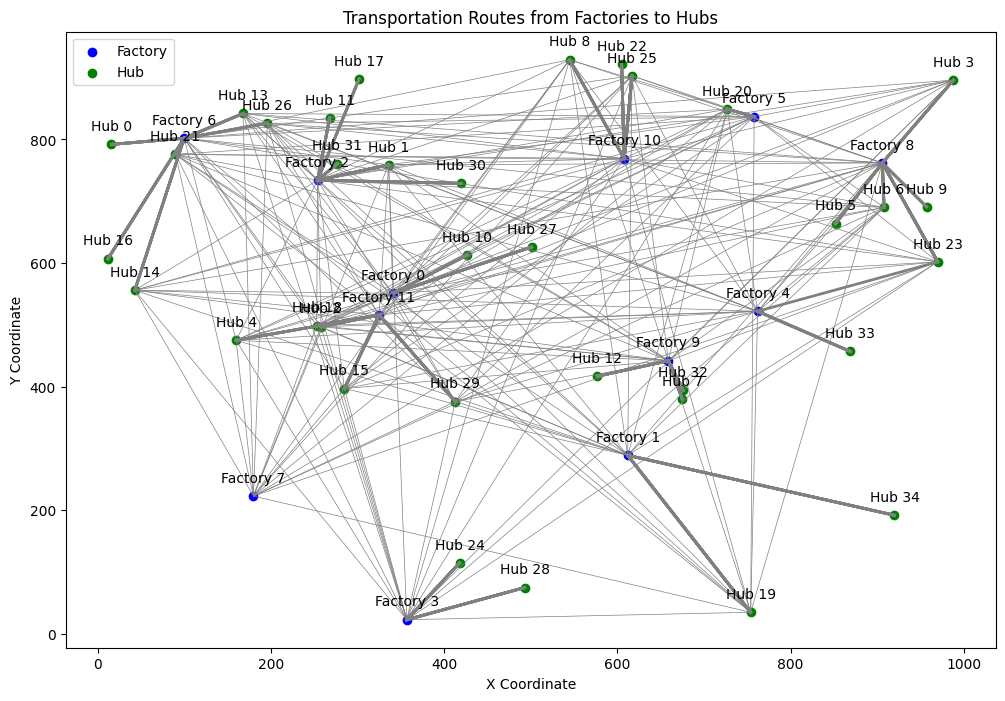

In [17]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))

# Vẽ các nhà máy
for i in range(NUM_FACTORIES):
    plt.scatter(factory_locations[i][0], factory_locations[i][1], c='blue', label='Factory' if i == 0 else "")
    plt.annotate(f'Factory {i}', (factory_locations[i][0], factory_locations[i][1]), textcoords="offset points", xytext=(0,10), ha='center')

# Vẽ các kho
for j in range(NUM_HUBS):
    plt.scatter(hub_locations[j][0], hub_locations[j][1], c='green', label='Hub' if j == 0 else "")
    plt.annotate(f'Hub {j}', (hub_locations[j][0], hub_locations[j][1]), textcoords="offset points", xytext=(0,10), ha='center')

# Vẽ các đường nối giữa nhà máy và kho nếu lượng hàng hóa vận chuyển lớn hơn 0
for i in range(NUM_FACTORIES):
    for j in range(NUM_HUBS):
        for k in range(NUM_SKUS):
            if x[i][j][k].solution_value() > 0:
                # Điều chỉnh độ dày của đường nối dựa trên lượng hàng hóa
                if x[i][j][k].solution_value() > 20:
                    line_width = 2  # Đường line đậm hơn
                else:
                    line_width = 0.5  # Đường line bé hơn

                plt.plot([factory_locations[i][0], hub_locations[j][0]],
                         [factory_locations[i][1], hub_locations[j][1]],
                         c='gray', linewidth=line_width)

plt.legend()
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Transportation Routes from Factories to Hubs')
plt.show()

SCIPY


In [ ]:
import numpy as np
from scipy.optimize import linprog
from numba import njit
import math
import time

# Constants definition
NUM_FACTORIES: int = 12
NUM_HUBS: int = 35
NUM_SKUS: int = 10
# MAX_DISTANCE = 500  # Example maximum distance for constraint

@njit
def generate_fake_data():
    """Generate fake data for supply, demand, and locations."""
    np.random.seed(42)  # Ensuring reproducibility
    supply = np.random.randint(10, 10000, (NUM_FACTORIES, NUM_SKUS))
    demand = np.random.randint(1, 50, (NUM_HUBS, NUM_SKUS))
    factory_locations = np.random.randint(1, 1000, (NUM_FACTORIES, 2))
    hub_locations = np.random.randint(1, 1000, (NUM_HUBS, 2))
    a = np.random.randint(0, 3, (NUM_FACTORIES, NUM_HUBS))
    return supply, demand, factory_locations, hub_locations, a

@njit
def calculate_distance(points1: np.ndarray, points2: np.ndarray) -> np.ndarray:
    """Calculate Euclidean distances between two sets of coordinates."""
    num_points1 = points1.shape[0]
    num_points2 = points2.shape[0]
    distances = np.empty((num_points1, num_points2), dtype=np.float32)
    for i in range(num_points1):
        for j in range(num_points2):
            distances[i, j] = math.sqrt((points1[i, 0] - points2[j, 0]) ** 2 +
                                        (points1[i, 1] - points2[j, 1]) ** 2)
    return distances

@njit
def compute_index1(f: int, h: int, s: int) -> int:
    """Calculate the index for factory-hub flow variables."""
    return f * NUM_HUBS * NUM_SKUS + h * NUM_SKUS + s

@njit
def populate_cost_coefficients(DM_fh: np.ndarray, onoff_hub: np.ndarray) -> np.ndarray:
    """Populate and return the cost coefficients for the linear programming problem, considering active hubs and customers."""
    num_variables = NUM_FACTORIES * NUM_HUBS * NUM_SKUS
    cost_coefficients = np.zeros(num_variables, dtype=np.float32)
    for f in range(NUM_FACTORIES):
        for h in range(NUM_HUBS):
            if onoff_hub[h]:  # Only consider active hubs
                for s in range(NUM_SKUS):
                    idx = compute_index1(f, h, s)
                    cost_coefficients[idx] = DM_fh[f, h]
    return cost_coefficients

@njit
def setup_hub_balance_constraints(onoff_hub: np.ndarray) -> (np.ndarray, np.ndarray):
    """Set up and return the equality constraints matrix and vector for hub balance, considering active hubs only."""
    num_variables = NUM_FACTORIES * NUM_HUBS * NUM_SKUS
    A_eq = np.zeros((NUM_HUBS * NUM_SKUS, num_variables), dtype=np.int_)
    b_eq = np.zeros((NUM_HUBS * NUM_SKUS), dtype=np.int_)
    for h in range(NUM_HUBS):
        if onoff_hub[h]:  # Only consider active hubs
            for s in range(NUM_SKUS):
                b_eq[h * NUM_SKUS + s] = demand[h, s]
                for f in range(NUM_FACTORIES):
                    A_eq[h * NUM_SKUS + s, compute_index1(f, h, s)] = 1
    return A_eq, b_eq

@njit
def create_constraints(S: np.ndarray, D: np.ndarray, onoff_hub) -> (np.ndarray, np.ndarray):
    """Create upper bound constraints for supply and demand satisfaction, considering active customers."""
    num_variables = NUM_FACTORIES * NUM_HUBS * NUM_SKUS
    A_ub = np.zeros((NUM_FACTORIES * NUM_SKUS + NUM_FACTORIES * NUM_HUBS, num_variables), dtype=np.int_)
    b_ub = np.zeros(NUM_FACTORIES * NUM_SKUS + NUM_FACTORIES * NUM_HUBS, dtype=np.int_)
    count = 0

    # Supply constraints for all factories
    for f in range(NUM_FACTORIES):
        for s in range(NUM_SKUS):
            for h in range(NUM_HUBS):
                if onoff_hub[h]:
                    index = compute_index1(f, h, s)
                    A_ub[count, index] = 1
            b_ub[count] = S[f, s]
            count += 1

    # Distance constraints for all factory-hub pairs
    for f in range(NUM_FACTORIES):
        for h in range(NUM_HUBS):
            if onoff_hub[h] and DM_fh[f, h] > MAX_DISTANCE:
                for s in range(NUM_SKUS):
                    index = compute_index1(f, h, s)
                    A_ub[count, index] = 1
            b_ub[count] = 0
            count += 1

    return A_ub, b_ub

# Generate data
supply, demand, factory_locations, hub_locations, a = generate_fake_data()
DM_fh = calculate_distance(factory_locations, hub_locations)
onoff_hub = np.random.randint(1, 2, len(hub_locations))  # Active hubs
time1= time.time()
MAX_DISTANCE = np.mean(DM_fh)

# Populate cost coefficients
cost_coefficients = populate_cost_coefficients(DM_fh, onoff_hub)

# Set up equality and inequality constraints
A_eq, b_eq = setup_hub_balance_constraints(onoff_hub)
A_ub, b_ub = create_constraints(supply, demand, onoff_hub)

# Define bounds for variables
bounds = [(0, None) for _ in range(len(cost_coefficients))]
print(time.time()-time1, "finish model")
time1= time.time()
#https://docs.scipy.org/doc/scipy/reference/optimize.linprog-highs-ds.html#optimize-linprog-highs-ds

result = linprog(cost_coefficients, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
print(time.time()-time1, "finish solving")
# # Solve the problem using linear programming
# result = linprog(cost_coefficients, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')

if result.success:
    print('Optimal solution found. Cost:', result.fun)
    print('Slack:', result.slack)
    print('Solution:', result.x)
    print('Status:', result.status)
    print('Message:', result.message)
else:
    print('No optimal solution found:', result.message)


2.0169456005096436 finish model
0.10564780235290527 finish solving
Optimal solution found. Cost: 1183624.9551315308
Slack: [7228.  852. 5352. 5131. 5723. 6217.  450. 4395. 5543. 8278. 1603.  722.
 6902. 2370. 5282. 5028. 6384. 1135. 4511. 3300. 6252. 8566. 9143. 2418.
 7742. 1928. 2650. 9066.  106. 2623. 2970. 4617. 1840. 7696. 1260. 1469.
 3512. 3827. 8807. 5350. 8799. 8431. 7497. 2606. 7014. 9465. 6216. 5482.
 7081. 9675.  752. 8231. 3114. 1576. 3949. 7526. 3034. 1014. 3809. 7971.
 9541. 6742. 5485.   22. 4206.  890. 7411. 9324.  905. 7700. 6449. 7902.
 6873. 7926. 8539.  888. 9278. 4897. 4869. 6341. 8424. 8543. 7109. 5243.
 1875.    0. 7847. 2446. 5321. 1921. 2630. 9621. 5174. 5516. 6671.  317.
 5855. 3531. 6144. 2988. 6173. 8291. 3034. 7131. 2397. 8937. 2666. 8068.
 9721. 5030. 7990. 3741.  884. 7300.  396. 6780. 8926. 6803. 4323.   31.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 